In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "z:\Program Files\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "z:\Program Files\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "z:\Program Files\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "z:\Program Files\Python\Python310\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
    app.start()
  File "z:

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "z:\Program Files\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "z:\Program Files\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "z:\Program Files\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "z:\Program Files\Python\Python310\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
    app.start()
  File "z:

AttributeError: _ARRAY_API not found

In [2]:
df = pd.read_csv('output.csv')
rqst_df = pd.read_csv('send_request_ns.csv')

column_names = df.columns.values

print("Column names:", column_names)
print("Data shape:", df.shape)

column_names_rqst = rqst_df.columns.values

print("Column names:", column_names_rqst)
print("Data shape:", rqst_df.shape)

for x in column_names:
    if not 'ns' in x:
        continue
    print(x)
    df[x] = df[x] / 1_000_000



Column names: ['test_id' 'query_id' 'pre1_ns' 'pre2_ns' 'pre3_ns' 'pre1_fix_ns'
 'post1_ipc_ns' 'post2_ipc_ns' 'post3_ipc_ns' 'post4_ipc_ns'
 'post1_tcp_ns' 'post2_tcp_ns' 'post3_tcp_ns' 'request_counter']
Data shape: (679, 14)
Column names: ['send_request_ns']
Data shape: (196, 1)
pre1_ns
pre2_ns
pre3_ns
pre1_fix_ns
post1_ipc_ns
post2_ipc_ns
post3_ipc_ns
post4_ipc_ns
post1_tcp_ns
post2_tcp_ns
post3_tcp_ns


In [3]:
df['pre_mean_ns'] = df[['pre1_ns', 'pre2_ns', 'pre3_ns', 'pre1_fix_ns']].mean(axis=1)
df['pre_median_ns'] = df[['pre1_ns', 'pre2_ns', 'pre3_ns', 'pre1_fix_ns']].median(axis=1)
df['post_mean_ipc_ns'] = df[['post1_ipc_ns', 'post2_ipc_ns', 'post3_ipc_ns', 'post4_ipc_ns']].mean(axis=1)
df['post_median_ipc_ns'] = df[['post1_ipc_ns', 'post2_ipc_ns', 'post3_ipc_ns', 'post4_ipc_ns']].median(axis=1)
df['post_mean_tcp_ns'] = df[['post1_tcp_ns', 'post2_tcp_ns', 'post3_tcp_ns']].mean(axis=1)
df['post_median_tcp_ns'] = df[['post1_tcp_ns', 'post2_tcp_ns', 'post3_tcp_ns']].median(axis=1)
print(df['pre_mean_ns'].mean())
print(df['post_mean_ipc_ns'].mean())
print(df['post_mean_tcp_ns'].mean())

send_request_mean = rqst_df['send_request_ns'].mean()
print(send_request_mean)
df['min_overhead'] = df['request_counter'] * send_request_mean
print(df['min_overhead'].head())

df['introduced_overhead'] = df['post_mean_ipc_ns'] - df['pre_mean_ns']


df['unique_id'] = df['test_id'].astype(str) + '-' + df['query_id'].astype(str)
print(df['unique_id'].head())

148.51922212739322
390.59988694918997
406.7821243662249
5357.765306122449
0    8.036648e+04
1    1.216213e+06
2    8.786735e+05
3    4.816631e+06
4    3.214659e+05
Name: min_overhead, dtype: float64
0    1505-1
1    1506-1
2    1506-2
3    1506-3
4    1506-4
Name: unique_id, dtype: object


In [4]:
df_filtered = df[df['query_id'] != 1]

df_ = df#df_filtered

count = (df_['post_mean_tcp_ns'] < df_['pre_mean_ns']).sum()

print(f"Evaluation True for {count} / {len(df_)} queries,")
print(f"Percentage: {count/len(df_)*100:.2f}%")

Evaluation True for 501 / 679 queries,
Percentage: 73.78%


In [5]:
# Create safe copy
df_copy = df.copy()

# Add fastest column using loc and nested np.where()
df_copy.loc[:, 'fastest_mean_ns'] = np.where(
    df_copy['pre_mean_ns'] <= df_copy[['post_mean_ipc_ns', 'post_mean_tcp_ns']].min(axis=1),
    'pre_mean_ns',
    np.where(
        df_copy['post_mean_ipc_ns'] <= df_copy['post_mean_tcp_ns'],
        'post_mean_ipc_ns',
        'post_mean_tcp_ns'
    )
)

# Reassign back to original
df = df_copy
print(df['fastest_mean_ns'].value_counts())

fastest_mean_ns
post_mean_tcp_ns    259
post_mean_ipc_ns    247
pre_mean_ns         173
Name: count, dtype: int64


Total entries: 679
Valid pre_mean_ns values: 679


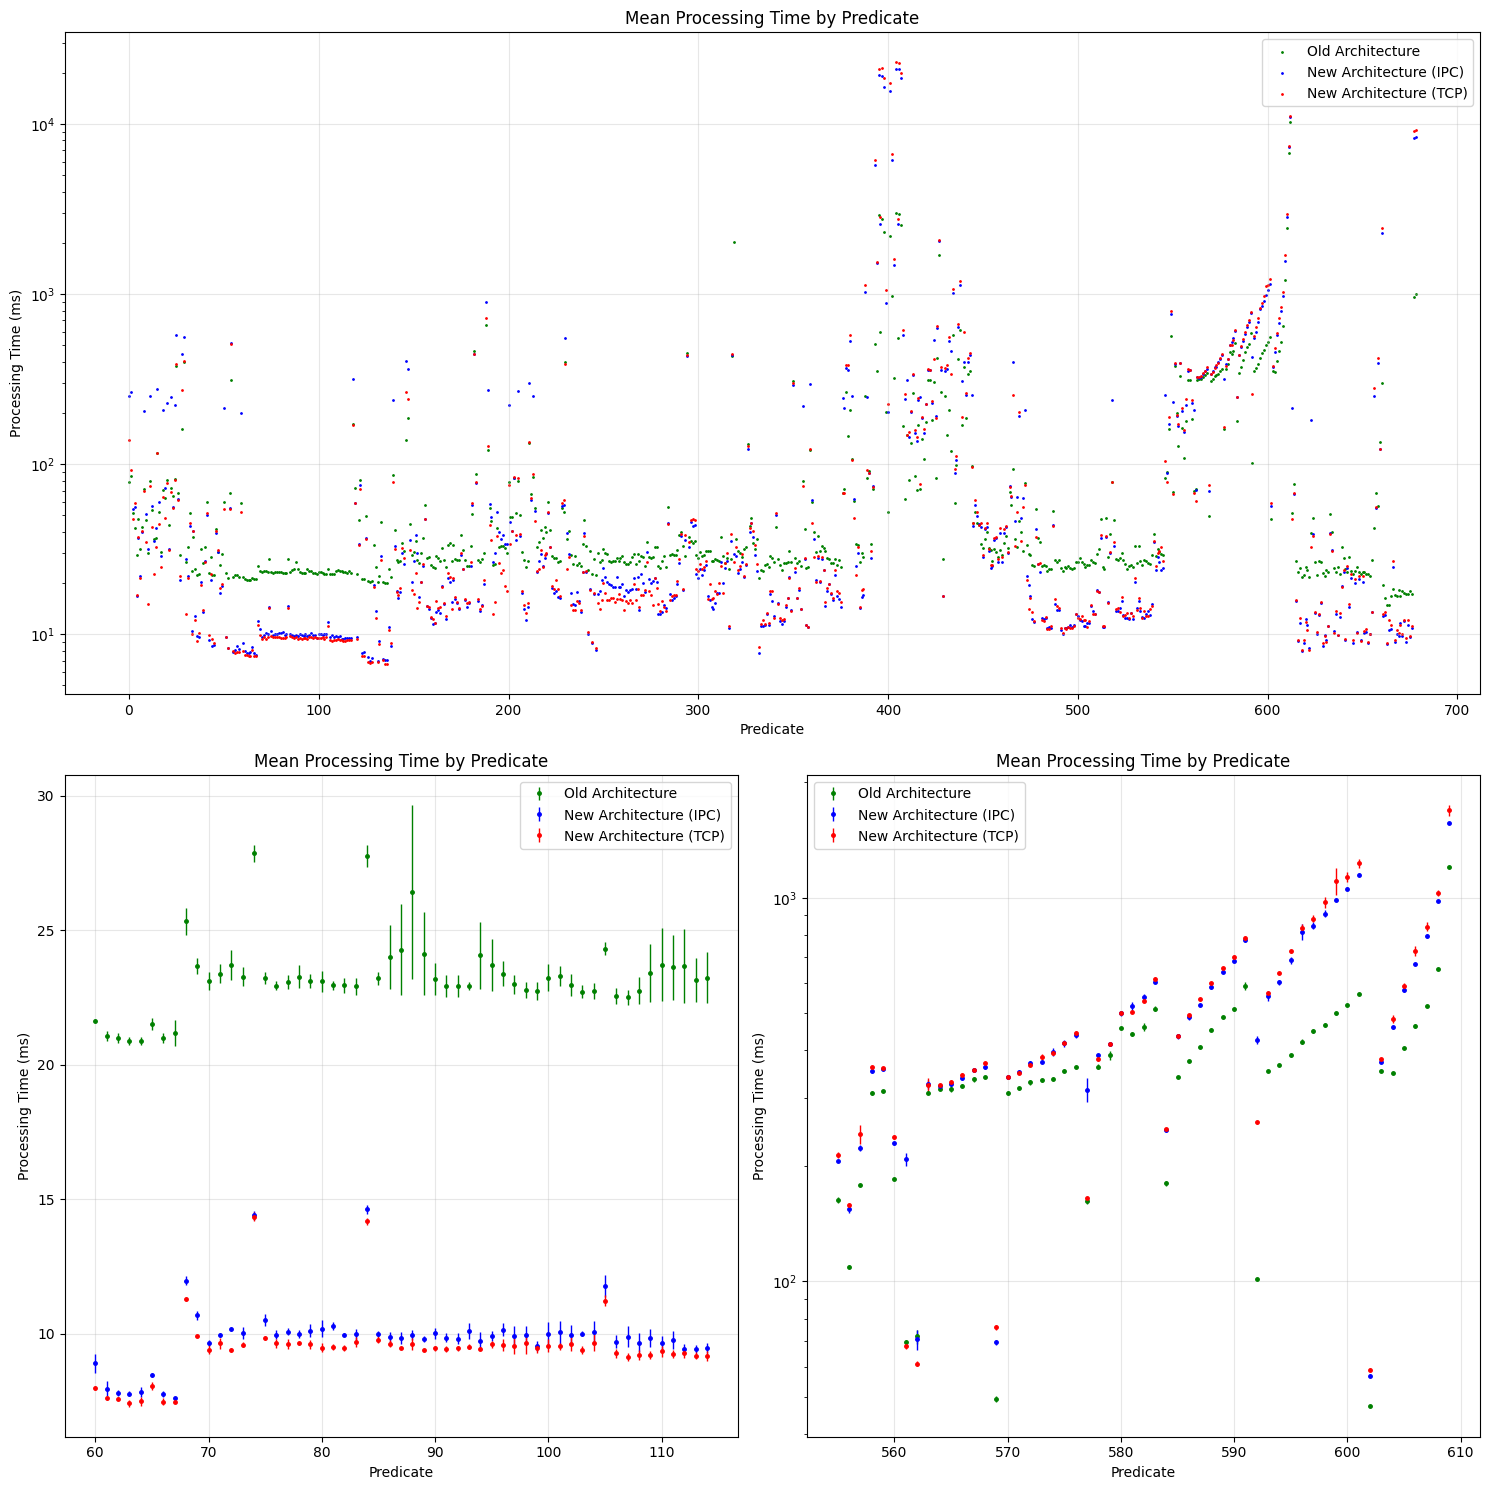

In [15]:
# df_mask = df[(df['pre_mean_ns'] < df['pre_mean_ns'].mean()) & (df['query_id'] != 1)]
quantile = 0.95
# df_mask = df[(df['pre_mean_ns'] < df['pre_mean_ns'].quantile(quantile)) & 
#     (df['post_mean_ipc_ns'] < df['post_mean_ipc_ns'].quantile(quantile)) & 
#     (df['post_mean_tcp_ns'] < df['post_mean_tcp_ns'].quantile(quantile))]# &
    # (df['query_id'] != 1)]
df_mask = df

print(f"Total entries: {len(df_mask)}")
print(f"Valid pre_mean_ns values: {df_mask['pre_mean_ns'].count()}")



# rohdaten

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

axs[0][0].remove()
axs[0][1].remove()
axs[0][0] = fig.add_subplot(2, 1, 1)
# axs[0][0].errorbar(range(len(df_mask)), df_mask['pre_mean_ns'], yerr=stdandardabweichung_pre, fmt='.',elinewidth=1, markersize='5', color='green', alpha=1, label='Old Architecture')
axs[0][0].scatter(range(len(df_mask)), df_mask['pre_mean_ns'], s=1, color='green', alpha=1, label='Old Architecture')
axs[0][0].scatter(range(len(df_mask)), df_mask['post_mean_ipc_ns'], s=1, color='blue', alpha=1, label='New Architecture (IPC)')
axs[0][0].scatter(range(len(df_mask)), df_mask['post_mean_tcp_ns'], s=1, color='red', alpha=1, label='New Architecture (TCP)')
axs[0][0].set_xlabel('Predicate')
axs[0][0].set_ylabel('Processing Time (ms)')
axs[0][0].set_yscale('log')  # Apply log scale to y-axis if needed
axs[0][0].set_title('Mean Processing Time by Predicate')
axs[0][0].grid(True, alpha=0.3)
axs[0][0].legend()

offset = 60
df_mask = df[offset:115]
stdandardabweichung_pre = df_mask[['pre1_ns', 'pre2_ns', 'pre3_ns', 'pre1_fix_ns']].std(axis=1)
stdandardabweichung_post_ipc = df_mask[['post1_ipc_ns', 'post2_ipc_ns', 'post3_ipc_ns', 'post4_ipc_ns']].std(axis=1)
stdandardabweichung_post_tcp = df_mask[['post1_tcp_ns', 'post2_tcp_ns', 'post3_tcp_ns']].std(axis=1)

stdandardabweichung_pre /= 2 # mal 1 durch wurzel n (n = anzahl messungen)
stdandardabweichung_post_ipc /= 2
stdandardabweichung_post_tcp /= 1.732
# nicht standardabweichung der grundgesamtheit sondern standardfehler des mitelwertes
# also statistische messunsicherheiten ohne die systematischen messunsicherheiten

# axs[1][0].scatter(range(offset, offset+len(df_mask)), df_mask['pre_mean_ns'], s=1, color='green', alpha=1, label='Old Architecture')
# axs[1][0].scatter(range(offset, offset+len(df_mask)), df_mask['post_mean_ipc_ns'], s=1, color='blue', alpha=1, label='New Architecture (IPC)')
# axs[1][0].scatter(range(offset, offset+len(df_mask)), df_mask['post_mean_tcp_ns'], s=1, color='red', alpha=1, label='New Architecture (TCP)')
axs[1][0].errorbar(range(offset, offset+len(df_mask)), df_mask['pre_mean_ns'], yerr=stdandardabweichung_pre , fmt='.', elinewidth=1, markersize='5', color='green', alpha=1, label='Old Architecture')
axs[1][0].errorbar(range(offset, offset+len(df_mask)), df_mask['post_mean_ipc_ns'], yerr=stdandardabweichung_post_ipc,  fmt='.', elinewidth=1, markersize='5', color='blue', alpha=1, label='New Architecture (IPC)')
axs[1][0].errorbar(range(offset, offset+len(df_mask)), df_mask['post_mean_tcp_ns'], yerr=stdandardabweichung_post_tcp, fmt='.', elinewidth=1, markersize='5', color='red', alpha=1, label='New Architecture (TCP)')
axs[1][0].set_xlabel('Predicate')
axs[1][0].set_ylabel('Processing Time (ms)')
axs[1][0].set_title('Mean Processing Time by Predicate')
axs[1][0].grid(True, alpha=0.3)
axs[1][0].legend()

offset = 555
df_mask = df[offset:610]
stdandardabweichung_pre = df_mask[['pre1_ns', 'pre2_ns', 'pre3_ns', 'pre1_fix_ns']].std(axis=1)
stdandardabweichung_post_ipc = df_mask[['post1_ipc_ns', 'post2_ipc_ns', 'post3_ipc_ns', 'post4_ipc_ns']].std(axis=1)
stdandardabweichung_post_tcp = df_mask[['post1_tcp_ns', 'post2_tcp_ns', 'post3_tcp_ns']].std(axis=1)

stdandardabweichung_pre /= 2 # mal 1 durch wurzel n (n = anzahl messungen)
stdandardabweichung_post_ipc /= 2
stdandardabweichung_post_tcp /= 1.732

# axs[1][1].scatter(range(offset, offset+len(df_mask)), df_mask['pre_mean_ns'], s=1, color='green', alpha=1, label='Old Architecture')
# axs[1][1].scatter(range(offset, offset+len(df_mask)), df_mask['post_mean_ipc_ns'], s=1, color='blue', alpha=1, label='New Architecture (IPC)')
# axs[1][1].scatter(range(offset, offset+len(df_mask)), df_mask['post_mean_tcp_ns'], s=1, color='red', alpha=1, label='New Architecture (TCP)')
axs[1][1].errorbar(range(offset, offset+len(df_mask)), df_mask['pre_mean_ns'], yerr=stdandardabweichung_pre , fmt='.', elinewidth=1, markersize='5', color='green', alpha=1, label='Old Architecture')
axs[1][1].errorbar(range(offset, offset+len(df_mask)), df_mask['post_mean_ipc_ns'], yerr=stdandardabweichung_post_ipc,  fmt='.', elinewidth=1, markersize='5', color='blue', alpha=1, label='New Architecture (IPC)')
axs[1][1].errorbar(range(offset, offset+len(df_mask)), df_mask['post_mean_tcp_ns'], yerr=stdandardabweichung_post_tcp, fmt='.', elinewidth=1, markersize='5', color='red', alpha=1, label='New Architecture (TCP)')
axs[1][1].set_xlabel('Predicate')
axs[1][1].set_ylabel('Processing Time (ms)')
axs[1][1].set_yscale('log')  # Apply log scale to y-axis if needed
axs[1][1].set_title('Mean Processing Time by Predicate')
axs[1][1].grid(True, alpha=0.3)
axs[1][1].legend()


plt.tight_layout()
# plt.show()
plt.savefig('processingtime.pdf')
plt.savefig('processingtime.png')

# -> 


(428,)
fastest_mean_ns
post_mean_ipc_ns    221
post_mean_tcp_ns    200
pre_mean_ns           7
Name: count, dtype: int64
26.916245899532715 16.49517522780374 16.090157560747663 93.13084112149532


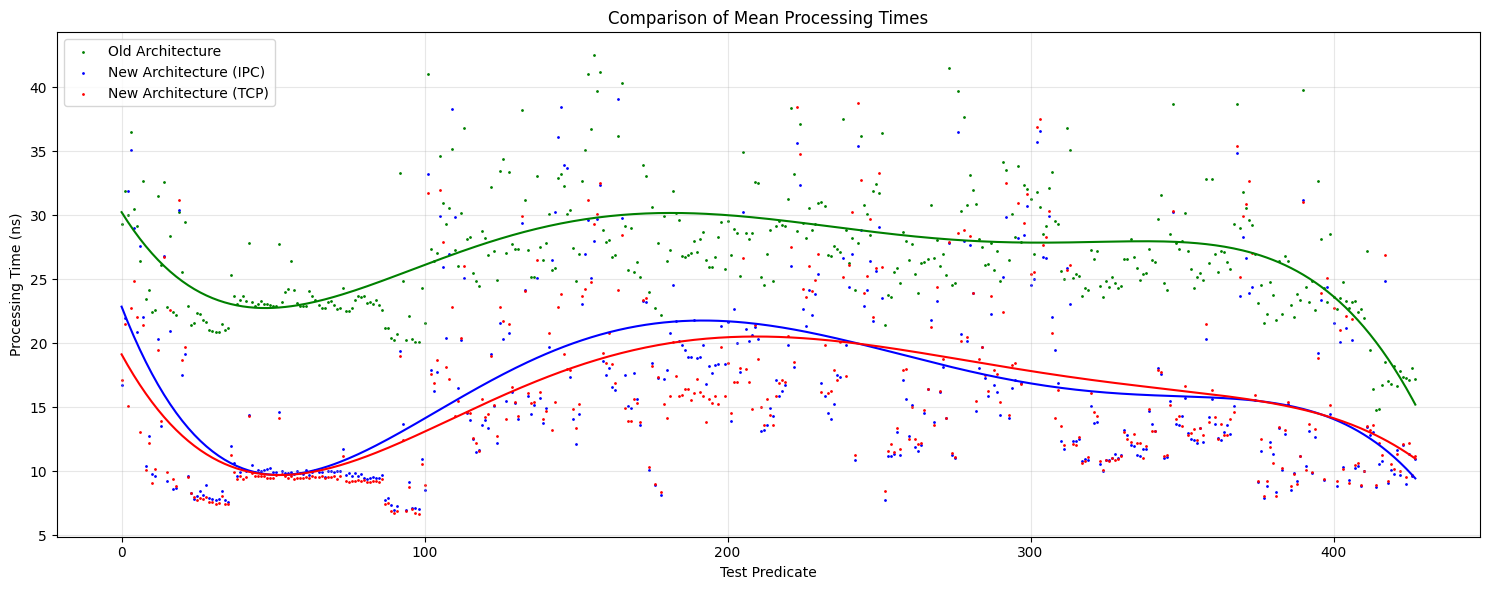

In [7]:
tolerance = 25
quantile = 0.95
df_mask = df#[(df['query_id'] != 1)]

# find the entries, such that at most tolerance entries have pre_mean_ns as fastest mean time
while df_mask['fastest_mean_ns'].value_counts().get('pre_mean_ns', 0) > tolerance:
    x = df_mask['pre_mean_ns'].quantile(quantile)
    df_mask = df[(df['pre_mean_ns'] < x) & 
                 (df['post_mean_ipc_ns'] < x) & 
                 (df['post_mean_tcp_ns'] < x)]


# invert the mask
# df_mask = df[(df['pre_mean_ns'] >= x) & 
#                 (df['post_mean_ipc_ns'] >= x) & 
#                 (df['post_mean_tcp_ns'] >= x)]

# df_mask = df[(df['pre_mean_ns'] < df['post_mean_ipc_ns'])]

# exclude the top 5% of values (extremes)

df_mask = df_mask[(df_mask['pre_mean_ns'] < df_mask['pre_mean_ns'].quantile(quantile)) &
    (df_mask['post_mean_ipc_ns'] < df_mask['post_mean_ipc_ns'].quantile(quantile)) &
    (df_mask['post_mean_tcp_ns'] < df_mask['post_mean_tcp_ns'].quantile(quantile))]


print(df_mask['fastest_mean_ns'].shape)
print(df_mask['fastest_mean_ns'].value_counts())
print(df_mask['pre_mean_ns'].mean(), df_mask['post_mean_ipc_ns'].mean(), df_mask['post_mean_tcp_ns'].mean(), df_mask['request_counter'].mean())

# Plot the data
plt.figure(figsize=(15, 6))
# Create line plots for each mean time
# plt.plot(df_mask.index, df_mask['pre_mean_ns'], color='green', alpha=0.5, label='pre_mean_ns')
# plt.plot(df_mask.index, df_mask['post_mean_ipc_ns'], color='blue', alpha=0.5, label='post_mean_ipc_ns')
# plt.plot(df_mask.index, df_mask['post_mean_tcp_ns'], color='red', alpha=0.5, label='post_mean_tcp_ns')
# Create scatter plots for each mean time
plt.scatter(range(len(df_mask)), df_mask['pre_mean_ns'], s=1, color='green', alpha=1, label='Old Architecture')
plt.scatter(range(len(df_mask)), df_mask['post_mean_ipc_ns'], s=1, color='blue', alpha=1, label='New Architecture (IPC)')
plt.scatter(range(len(df_mask)), df_mask['post_mean_tcp_ns'], s=1, color='red', alpha=1, label='New Architecture (TCP)')


pre_mean_ns_x = np.arange(len(df_mask['pre_mean_ns']))
pre_mean_ns_y = df_mask['pre_mean_ns'].values
post_mean_ipc_ns_x = np.arange(len(df_mask['post_mean_ipc_ns']))
post_mean_ipc_ns_y = df_mask['post_mean_ipc_ns'].values
post_mean_tcp_ns_x = np.arange(len(df_mask['post_mean_tcp_ns']))
post_mean_tcp_ns_y = df_mask['post_mean_tcp_ns'].values

# Fit polynomial (degree=3 for cubic fit)
pre_mean_ns_coefficients = np.polyfit(pre_mean_ns_x, pre_mean_ns_y, 5)
pre_mean_ns_polynomial = np.poly1d(pre_mean_ns_coefficients)
post_mean_ipc_ns_coefficients = np.polyfit(post_mean_ipc_ns_x, post_mean_ipc_ns_y, 5)
post_mean_ipc_ns_polynomial = np.poly1d(post_mean_ipc_ns_coefficients)
post_mean_tcp_ns_coefficients = np.polyfit(post_mean_tcp_ns_x, post_mean_tcp_ns_y, 5)
post_mean_tcp_ns_polynomial = np.poly1d(post_mean_tcp_ns_coefficients)

# Calculate fitted values
pre_mean_ns_y_fitted = pre_mean_ns_polynomial(pre_mean_ns_x)
post_mean_ipc_ns_y_fitted = post_mean_ipc_ns_polynomial(post_mean_ipc_ns_x)
post_mean_tcp_ns_y_fitted = post_mean_tcp_ns_polynomial(post_mean_tcp_ns_x)

# Add fitted values to dataframe
# df_mask['pre_mean_ns_fitted'] = pre_mean_ns_y_fitted
# df_mask['pre_mean_ns_fitted'] = post_mean_ipc_ns_y_fitted
# df_mask['pre_mean_ns_fitted'] = post_mean_tcp_ns_y_fitted
plt.plot(pre_mean_ns_x, pre_mean_ns_y_fitted, color='green')
plt.plot(post_mean_ipc_ns_x, post_mean_ipc_ns_y_fitted, color='blue')
plt.plot(post_mean_tcp_ns_x, post_mean_tcp_ns_y_fitted, color='red')


# Highlight the fastest mean time
# colors = {'pre_mean_ns': 'green', 'post_mean_ipc_ns': 'blue', 'post_mean_tcp_ns': 'red'}
# for key, group in df_mask.groupby('fastest_mean_ns'):
#     plt.scatter(group.index, group[key], s=10, color=colors[key], label=f'Fastest: {key}', edgecolor='black')

plt.xlabel('Test Predicate')
plt.ylabel('Processing Time (ns)')
plt.title('Comparison of Mean Processing Times')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

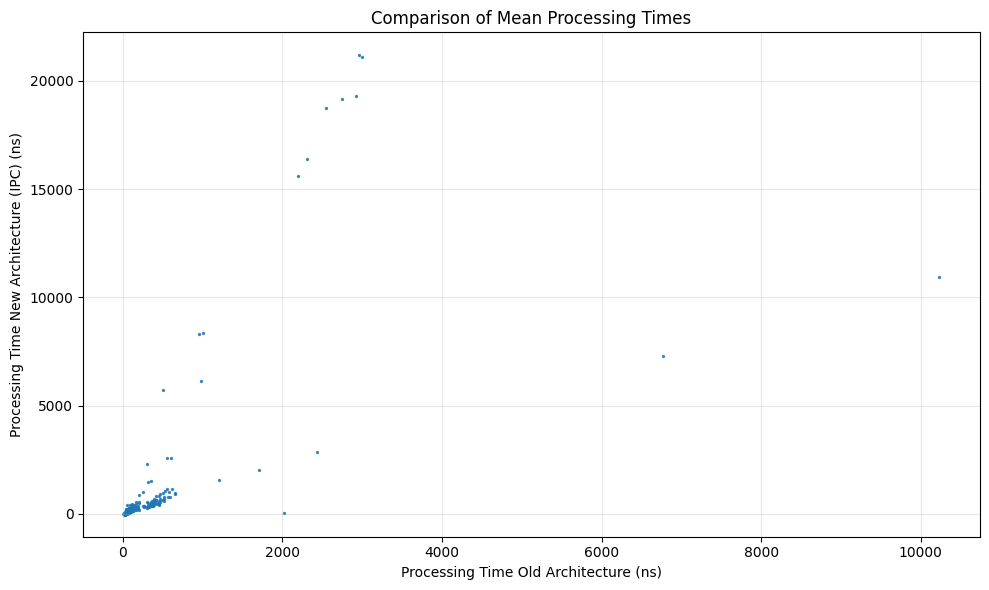

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(df['pre_mean_ns'], df['post_mean_ipc_ns'], s=2, alpha=0.8)
plt.xlabel('Processing Time Old Architecture (ns)')
plt.ylabel('Processing Time New Architecture (IPC) (ns)')
plt.title('Comparison of Mean Processing Times')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


(array([  0.02632829, -13.1464937 ]), array([[ 3.54097234e-08, -3.30771903e-06],
       [-3.30771903e-06,  1.40712556e-02]]))
     test_id  query_id    pre1_ns      pre2_ns      pre3_ns  pre1_fix_ns  \
319     2122        90  36.431769  4032.839388  3993.312955    42.535669   

     post1_ipc_ns  post2_ipc_ns  post3_ipc_ns  post4_ipc_ns  ...  \
319     31.168074      32.01447     30.883189     25.089715  ...   

     post_median_ipc_ns  post_mean_tcp_ns  post_median_tcp_ns   min_overhead  \
319           31.025632         26.453326           25.774042  637574.071429   

     introduced_overhead  unique_id   fastest_mean_ns     fit_diff  count  \
319         -1996.491083    2122-90  post_mean_tcp_ns -1986.477656      1   

     weight  
319     1.0  

[1 rows x 27 columns]


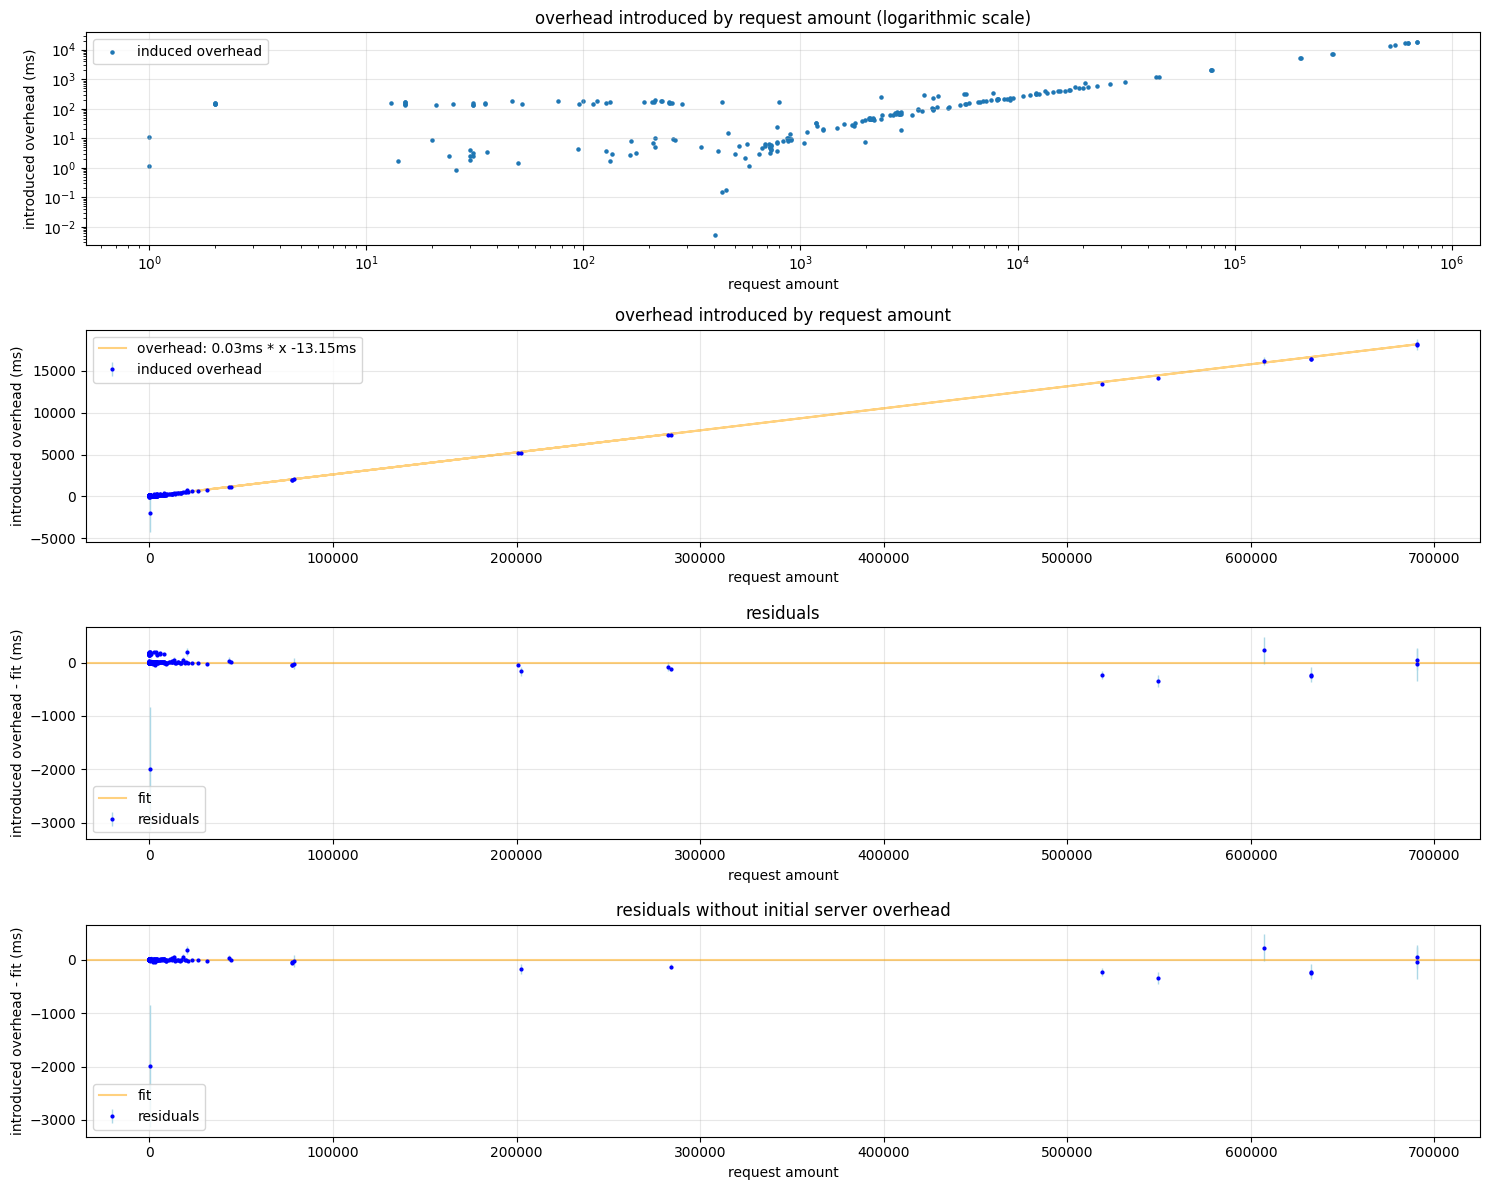

In [12]:
# systematiken erkennen
# initialer overhead ist sichtbar
# ein grooßer ausreißer bei dem was falsch lief
# 


# es wird angenommen dass die messfehler normalverteilt sind

fig, axs = plt.subplots(4, 1, figsize=(15, 12))

axs[0].scatter(df['request_counter'], df['introduced_overhead'], s=5, label='induced overhead')
axs[0].set_xlabel('request amount')
axs[0].set_ylabel('introduced overhead (ms)')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_title('overhead introduced by request amount (logarithmic scale)')
axs[0].grid(True, alpha=0.3)
axs[0].legend()

x = df['request_counter']
y = (df['introduced_overhead']).values
stdandardabweichung_pre = df[['pre1_ns', 'pre2_ns', 'pre3_ns', 'pre1_fix_ns']].std(axis=1)
stdandardabweichung_post_ipc = df[['post1_ipc_ns', 'post2_ipc_ns', 'post3_ipc_ns', 'post4_ipc_ns']].std(axis=1)
stdandardabweichung_post_tcp = df[['post1_tcp_ns', 'post2_tcp_ns', 'post3_tcp_ns']].std(axis=1)

u_diff = np.sqrt(stdandardabweichung_pre**2 + stdandardabweichung_post_ipc**2)

f = lambda x,a,b: a*x + b
fitted = curve_fit(f, x, y, sigma=u_diff)
print(fitted)
fitted_f = f(x, fitted[0][0], fitted[0][1])


axs[1].errorbar(df['request_counter'], df['introduced_overhead'], yerr=u_diff , fmt='.', elinewidth=1, markersize='4', color='blue', ecolor='lightblue', alpha=1, label='induced overhead')
axs[1].plot(df['request_counter'], fitted_f, alpha=0.5, color='orange', label=f'overhead: {fitted[0][0]:.2f}ms * x {fitted[0][1]:.2f}ms')
axs[1].set_xlabel('request amount')
axs[1].set_ylabel('introduced overhead (ms)')
axs[1].set_title('overhead introduced by request amount')
axs[1].grid(True, alpha=0.3)
axs[1].legend()


df['fit_diff'] = df['introduced_overhead'] - fitted_f

dfmask = df#[df['query_id'] != 1]
# dfmask = dfmask[dfmask['request_counter'] <= 5000]
# dfmask = dfmask[dfmask['request_counter'] >= 100]

stdandardabweichung_pre = dfmask[['pre1_ns', 'pre2_ns', 'pre3_ns', 'pre1_fix_ns']].std(axis=1)
stdandardabweichung_post_ipc = dfmask[['post1_ipc_ns', 'post2_ipc_ns', 'post3_ipc_ns', 'post4_ipc_ns']].std(axis=1)

stdandardabweichung_pre /= 2 # mal 1 durch wurzel n (n = anzahl messungen)
stdandardabweichung_post_ipc /= 2
stdandardabweichung_res = np.sqrt(stdandardabweichung_pre**2 + stdandardabweichung_post_ipc**2)

axs[2].errorbar(dfmask['request_counter'], dfmask['fit_diff'], yerr=stdandardabweichung_res , fmt='.', elinewidth=1, markersize='4', color='blue', ecolor='lightblue', alpha=1, label='residuals')
axs[2].axhline(0, alpha=0.5, color='orange', label='fit')
axs[2].set_xlabel('request amount')
axs[2].set_ylabel('introduced overhead - fit (ms)')
axs[2].set_title('residuals')
# axs[2].set_yscale('log')
# axs[2].set_xscale('log')
axs[2].grid(True, alpha=0.3)
axs[2].legend()



dfmask = df[df['query_id'] != 1]
# dfmask['fit_diff'] = dfmask['introduced_overhead'] - fitted_f
# dfmask = dfmask[dfmask['request_counter'] <= 5000]
# dfmask = dfmask[dfmask['request_counter'] >= 100]

stdandardabweichung_pre = dfmask[['pre1_ns', 'pre2_ns', 'pre3_ns', 'pre1_fix_ns']].std(axis=1)
stdandardabweichung_post_ipc = dfmask[['post1_ipc_ns', 'post2_ipc_ns', 'post3_ipc_ns', 'post4_ipc_ns']].std(axis=1)

stdandardabweichung_pre /= 2 # mal 1 durch wurzel n (n = anzahl messungen)
stdandardabweichung_post_ipc /= 2
stdandardabweichung_res = np.sqrt(stdandardabweichung_pre**2 + stdandardabweichung_post_ipc**2)

axs[3].errorbar(dfmask['request_counter'], dfmask['fit_diff'], yerr=stdandardabweichung_res , fmt='.', elinewidth=1, markersize='4', color='blue', ecolor='lightblue', alpha=1, label='residuals')
axs[3].axhline(0, alpha=0.5, color='orange', label='fit')
axs[3].set_xlabel('request amount')
axs[3].set_ylabel('introduced overhead - fit (ms)')
axs[3].set_title('residuals without initial server overhead')
axs[3].grid(True, alpha=0.3)
axs[3].legend()

plt.tight_layout()
# plt.show()
plt.savefig('overhead.pdf')
plt.savefig('overhead.png')


dfmask = df[df['introduced_overhead'] < -1800]
print(dfmask.head())



0    172.938896
1    179.130094
2      2.790885
3     14.035157
4    -12.603596
Name: introduced_overhead, dtype: float64
459


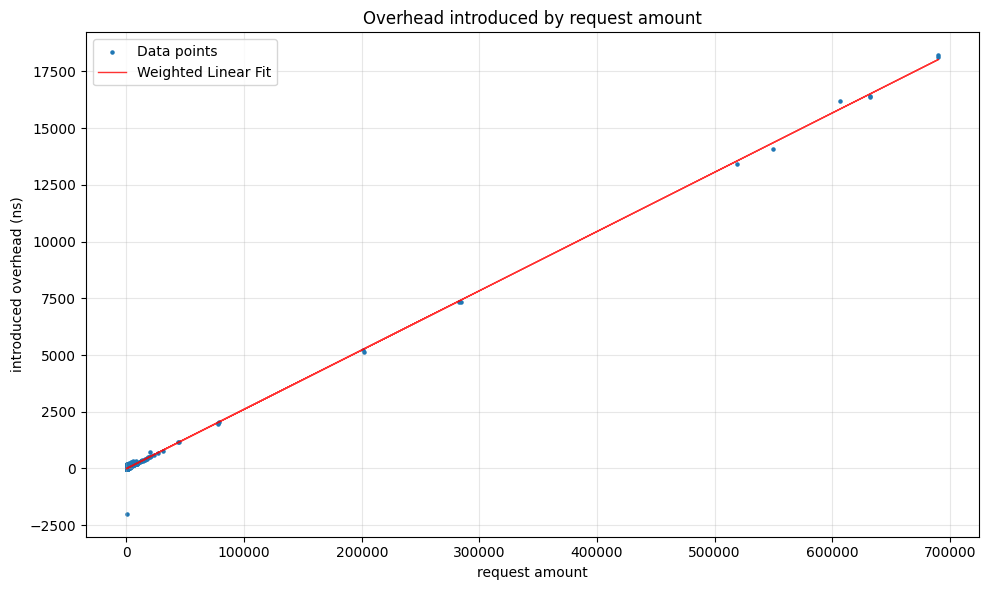

Intercept: -2.979499050757255
Slope: [0.02612102]


In [10]:

print(df['introduced_overhead'].head())
print((df['introduced_overhead'] < 0).sum())
# Calculate frequency (clumping points)
try:
    freq = df.groupby(['request_counter', 'introduced_overhead']).size().reset_index(name='count')
    df = pd.merge(df, freq, on=['request_counter', 'introduced_overhead'], how='left')
    df['weight'] = 1 / df['count']
except (KeyError, pd.errors.MergeError) as e:
    pass
# Weights as inverse frequency

# Extract X, y, and weights
X = df['request_counter'].values.reshape(-1, 1)  # Reshape for sklearn
y = df['introduced_overhead'].values
weights = df['weight'].values

# Fit weighted regression
model = LinearRegression()
model.fit(X, y, sample_weight=weights)

# Predict values
y_pred = model.predict(X)

# Plot data and weighted regression line
plt.figure(figsize=(10, 6))
plt.scatter(df['request_counter'], y, s=5, label='Data points')
plt.plot(df['request_counter'], y_pred, color='red', linewidth=1, alpha=0.8, label='Weighted Linear Fit')
plt.xlabel('request amount')
plt.ylabel('introduced overhead (ns)')
plt.title('Overhead introduced by request amount')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display coefficients
print("Intercept:", model.intercept_)
print("Slope:", model.coef_)